## Causal reasoning with linear models

The use of linear models, where possible, simplifies causal reasoning and allows one to use linear regression to determine path coefficients relating values.  They make life a lot easier.

This notebook shows how path coefficients are calculated on a synthetic dataset where we can control the correct values.  The dataset construction code is in dataset_N.py for N = 01, 02, 03 and useful functions are defined in causal_utils.py, all in the current directory.


In [1]:
import importlib
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx
import os
from random import random, seed, uniform, gauss
import re
import sys

from sklearn.linear_model import LinearRegression


In [2]:
import causal_utils as u

In [3]:
# Set a seed so that the results are reproducible.  The value is arbitrary and everything works without it

seed(12345)
np.random.seed(12345)

In [4]:
%matplotlib inline

pd.options.display.max_rows = 250
pd.options.display.max_columns = 125
pd.options.display.max_colwidth = 250

nx_options = {
    'node_color': 'orange',
    "edge_color": "blue",
    "with_labels": True,
    "font_weight": 'bold',
    "font_size": 12,
    'node_size': 1200,
    'width': 1,
    "arrowsize": 15,
}

# The accuracy is okay with 100k observations but a milion is better.
num_data_elts = 1_000_000


In [5]:
# Which dataset do we want to use?

dataset_index = 3

In [6]:
if dataset_index == 1:
    import dataset_01 as dataset
    from dataset_01 import g, draw_fn, observation

elif dataset_index == 2:
    import dataset_02 as dataset
    from dataset_02 import g, draw_fn, observation

elif dataset_index == 3:
    import dataset_03 as dataset
    from dataset_03 import g, draw_fn, observation


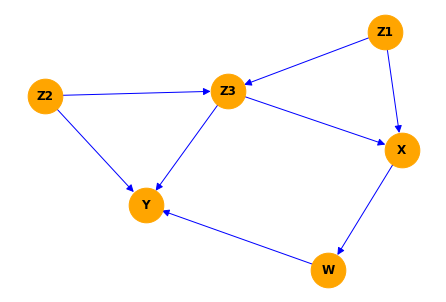

In [7]:
draw_fn(g, **nx_options)

In [8]:
data = [dataset.observation() for _ in range(num_data_elts)]
df = pd.DataFrame(data, columns=sorted(g.nodes))

In [9]:
# See the regression coefficients for predicting each variable from the others.
# Note how the variables that are d-separated from the target given the others have small coefficients

# Notice how the regression coefficients differ from the path coefficients computed below.
# This is because we are including every variable in the regression, instead of just the "parent" nodes.

for node in g.nodes:
    model_columns = [col for col in g.nodes if col != node]

    x_train = df[model_columns]
    y_train = df[node]
    
    model = LinearRegression().fit(x_train, y_train)

    print(node, dict(zip(model_columns, [np.round(coeff, 5) for coeff in model.coef_])))
    print()

Z1 {'X': -0.01957, 'Z3': 0.78532, 'Z2': -2.29766, 'Y': -5e-05, 'W': 0.00042}

X {'Z1': -0.12059, 'Z3': 0.06129, 'Z2': -0.00767, 'Y': 1e-05, 'W': 0.62742}

Z3 {'Z1': 1.0611, 'X': 0.01344, 'Z2': 2.44025, 'Y': 0.02267, 'W': -0.02313}

Z2 {'Z1': -0.41497, 'X': -0.00022, 'Z3': 0.32617, 'Y': 0.00083, 'W': -0.00067}

Y {'Z1': -0.02147, 'X': 0.00067, 'Z3': 7.02038, 'Z2': 1.92742, 'W': 1.00207}

W {'Z1': 0.00591, 'X': 1.44885, 'Z3': -0.24356, 'Z2': -0.0528, 'Y': 0.03408}



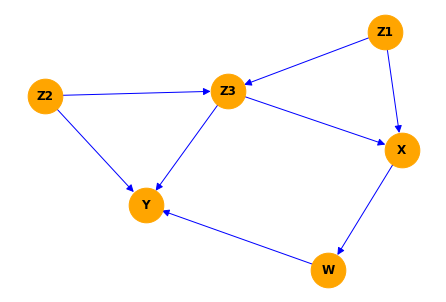

In [10]:
draw_fn(g, **nx_options)

In [11]:
# Because of the way we define the dataset functions, we can access the actual coefficients used in them

u.actual_coefficients(dataset.__dict__)

W_Y_coeff = 1
X_W_coeff = 1.5
Z1_X_coeff = -2
Z1_Z3_coeff = 1.25
Z2_Y_coeff = 2
Z2_Z3_coeff = 3
Z3_X_coeff = 1
Z3_Y_coeff = 7


In [12]:
# These are the estimates for the coefficients produced by linear regression

u.estimated_coefficients(g, df)

W Y 1.002750
X W 1.500100
Z1 X -1.998690
Z1 Z3 1.249950
Z2 Y 1.977040
Z2 Z3 2.999950
Z3 X 0.999790
Z3 Y 7.003490


By using the Python unittest mocking library, we can implement the do(V=v) operator without altering the source code.  This allows us to validate that regression really has given us the right answers

In [13]:
if dataset_index == 1:
    # total effect of B on Y = direct effect + effect via X
    print("%-11s %5.3f" % ("theoretical",
                           dataset.B_Y_coeff + dataset.B_X_coeff * dataset.X_Y_coeff))
    print()
    
    for sample in range(5):
        print("%-11s %5.3f" % ("empirical",
                               u.empirical_total_effect(g, dataset, "B", "Y",
                                                        lambda *a: 1, lambda *a: 2,
                                                        num_data_elts=num_data_elts)))

In [14]:
if dataset_index == 2:
    # total effect of X on Y = effect via A + effect via D
    print("%-11s %5.3f" % ("theoretical",
                           dataset.X_A_coeff * dataset.A_Y_coeff + dataset.X_D_coeff * dataset.D_Y_coeff))
    print()
    
    for sample in range(5):
        print("%-11s %5.3f" % ("empirical",
                               u.empirical_total_effect(g, dataset, "X", "Y",
                                                        lambda *a: 1, lambda *a: 2,
                                                        num_data_elts=num_data_elts)))

In [15]:
if dataset_index == 3:
    # total effect of Z3 on Y = direct effect + effect via X and W
    print("%-11s %5.3f" % ("theoretical",
                           dataset.Z3_Y_coeff + dataset.Z3_X_coeff * dataset.X_W_coeff * dataset.W_Y_coeff))
    print()
    
    for sample in range(5):
        print("%-11s %5.3f" % ("empirical",
                               u.empirical_total_effect(g, dataset, "Z3", "Y",
                                                        lambda *a: 1, lambda *a: 2,
                                                        num_data_elts=num_data_elts)))

theoretical 8.500

empirical   8.476
empirical   8.469
empirical   8.531
empirical   8.497
empirical   8.511


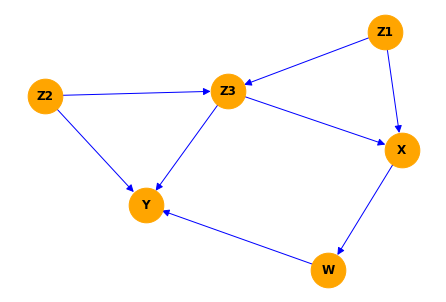

In [16]:
draw_fn(g, **nx_options)